DeePyMoD ODE Example

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
# from torch.autograd import grad
# from itertools import combinations
# from functools import reduce
# from typing import Tuple
# from deepymod.utils.types import TensorList
# from deepymod.model.library import Library
import libraryODE

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(30)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


# Preparing a new dataset
Firstly we prepare the dataset.
Therfore we load the time series from .mat file and transform it into a Dataset object.

### Simulated with miaSim

Interaction matrix 
$A = \begin{pmatrix}
-0.5 & 30 & 0 & 0\\
-15 & -0.5 & 0 | 3 & 0 \\
0 & 0 & -0.5 & 20\\
0 & 0 & -10 & -0.5
\end{pmatrix}$

and growth rates:
$ b = (2/3, -1, 0.7, -3)$

Specify the number of species n_species and the number of timepoints n_samples in the given dataset:

In [2]:
# n_samples = None
# n_species = None

n_samples = 500
n_species = 4

# path of data file
filename = f"miaSim_GLV_{n_species}species_oscillating_zero.mat"
# filename = f"miaSim_GLV_{n_species}species_oscillating_three.mat"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/01e-timeseries-miaSim/" + filename

# data should be of the form:
# [n_samples, (1 + n_species)]
# where the first colum contains the time t

# order of interactions included in the model (2 or 3)
int_order = 2

In [3]:
def create_data():
  data = loadmat(filepath)
  usol = np.real(data["ts_glv"]).astype("float32")
  usol = usol.reshape((n_samples, (1 + n_species)))
  ts = usol[:, 0]
  data_y = usol[:, 1:(1 + n_species)]
  T = torch.from_numpy(ts.reshape(-1, 1)).float()
  Y = torch.from_numpy(data_y).float()
  print("The coodinates have shape {}".format(T.shape))
  print("The data has shape {}".format(Y.shape))
  return T, Y

In [4]:
data = create_data()
print("Time:", data[0][0:10])
print("Data:", data[1][0:10])

The coodinates have shape torch.Size([500, 1])
The data has shape torch.Size([500, 4])
Time: tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]])
Data: tensor([[0.0818, 0.1822, 0.7035, 0.4503],
        [0.0678, 0.0997, 0.4374, 0.9899],
        [0.0866, 0.0564, 0.0858, 1.2470],
        [0.1325, 0.0484, 0.0480, 0.7218],
        [0.1806, 0.0835, 0.0929, 0.5132],
        [0.1402, 0.1549, 0.1627, 0.6575],
        [0.0927, 0.1194, 0.1155, 0.7941],
        [0.1014, 0.0733, 0.1001, 0.6788],
        [0.1393, 0.0693, 0.1217, 0.6551],
        [0.1550, 0.1092, 0.1243, 0.7112]])


Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [5]:
def custom_normalize(feature):
        """minmax all features by their absolute maximum
        Args:
            feature (torch.tensor): data to be minmax normalized
        Returns:
            (torch.tensor): minmaxed data"""
        return (feature/feature.abs().max(axis=0).values)

In [6]:
# # add noise to dataset
# dataset = Dataset(
#     create_data,
#     subsampler=Subsample_random,
#     subsampler_kwargs={"number_of_samples": 500},
#     preprocess_kwargs={
#         "noise_level": 0.01,
#         "normalize_coords": False,
#         "normalize_data": False,
#     },
#     apply_normalize=custom_normalize,
#     device=device
# )

In [7]:
dataset = Dataset(
    create_data,
    device = device,
)

The coodinates have shape torch.Size([500, 1])
The data has shape torch.Size([500, 4])
Dataset is using device:  cpu


Visualization of the dataset

Text(0.5, 1.0, 'Sampled and standardized data')

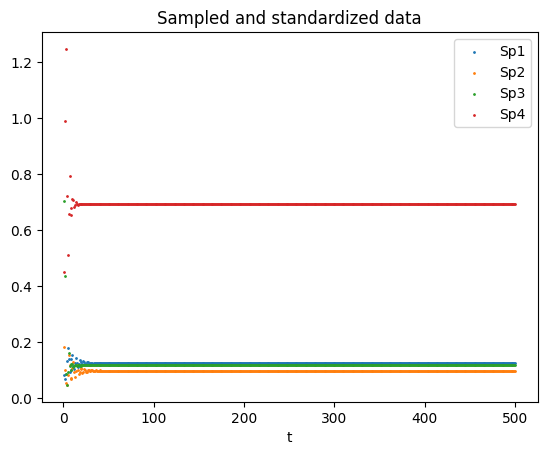

In [8]:
fig, ax = plt.subplots()
for i in np.arange(n_species):
    # plt.plot(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}")
    ax.scatter(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}", s=1)
ax.set_xlabel("t")
ax.legend()
# ax.set_title("Sampled and standardized data")
# plt.xlim([0,100])

Now we need to split our data into a train and test dataloaders for PyTorch

In [9]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [10]:
network = NN(1, [20, 20, 20, 20], n_species)

Configuration of the library function.

In [11]:
library = libraryODE.LibraryODE(int_order = int_order, intercept = False)

Show a list of the expressions contained in the library.

In [12]:
# get a list of coefficients contained in the library
library_values = library.get_content(dataset.data)

# number of coefficients per taxon
n_coefs = len(library_values[0])

# print the list
library_values

[['x1*1', 'x1*x1', 'x1*x2', 'x1*x3', 'x1*x4'],
 ['x2*1', 'x2*x1', 'x2*x2', 'x2*x3', 'x2*x4'],
 ['x3*1', 'x3*x1', 'x3*x2', 'x3*x3', 'x3*x4'],
 ['x4*1', 'x4*x1', 'x4*x2', 'x4*x3', 'x4*x4']]

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [13]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [14]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [15]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

Defining optimizer

In [16]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [17]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    # log_dir='runs/coupled/',
    log_dir="/data/deepymod/ODE_S4/",
    max_iterations=50000,
    delta=1e-3,
    patience=100,
)

     0  MSE: 9.37e-01  Reg: 1.50e-06  L1: 3.36e+03 

 49975  MSE: 2.17e-05  Reg: 2.35e-06  L1: 1.54e+02 Algorithm converged. Writing model to disk.


Now that DeepMoD has converged, it has found the following coefficients to not be zero:

In [18]:
model.sparsity_masks

[tensor([False, False,  True,  True,  True]),
 tensor([True, True, True, True, True]),
 tensor([True, True, True, True, True]),
 tensor([True, True, True, True, True])]

And it found the following coefficients.

In [19]:
model.estimator_coeffs()

[array([[  0.        ],
        [  0.        ],
        [-11.361702  ],
        [ -0.80143523],
        [ 12.186423  ]], dtype=float32),
 array([[ 5.6491637],
        [ 3.366551 ],
        [-0.33025  ],
        [-2.2465336],
        [-6.7468495]], dtype=float32),
 array([[ 3.2068536],
        [ 2.1153564],
        [ 0.4522244],
        [-1.2544384],
        [-5.168299 ]], dtype=float32),
 array([[-0.88284016],
        [-1.0768805 ],
        [ 3.687924  ],
        [ 3.2094407 ],
        [-4.861128  ]], dtype=float32)]

## Analysis/Visualization of the train() loss

In [20]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator

In [21]:
# get list of all output values that were calculated during train()
os.listdir("/data/deepymod/ODE_S4/")

['checkpoint.pt',
 'coeffs_output_0_coeff_0',
 'coeffs_output_0_coeff_1',
 'coeffs_output_0_coeff_2',
 'coeffs_output_0_coeff_3',
 'coeffs_output_0_coeff_4',
 'coeffs_output_0_coeff_5',
 'coeffs_output_0_coeff_6',
 'coeffs_output_0_coeff_7',
 'coeffs_output_0_coeff_8',
 'coeffs_output_0_coeff_9',
 'coeffs_output_1_coeff_0',
 'coeffs_output_1_coeff_1',
 'coeffs_output_1_coeff_2',
 'coeffs_output_1_coeff_3',
 'coeffs_output_1_coeff_4',
 'coeffs_output_1_coeff_5',
 'coeffs_output_1_coeff_6',
 'coeffs_output_1_coeff_7',
 'coeffs_output_1_coeff_8',
 'coeffs_output_1_coeff_9',
 'coeffs_output_2_coeff_0',
 'coeffs_output_2_coeff_1',
 'coeffs_output_2_coeff_2',
 'coeffs_output_2_coeff_3',
 'coeffs_output_2_coeff_4',
 'coeffs_output_2_coeff_5',
 'coeffs_output_2_coeff_6',
 'coeffs_output_2_coeff_7',
 'coeffs_output_2_coeff_8',
 'coeffs_output_2_coeff_9',
 'coeffs_output_3_coeff_0',
 'coeffs_output_3_coeff_1',
 'coeffs_output_3_coeff_2',
 'coeffs_output_3_coeff_3',
 'coeffs_output_3_coeff_4',
 '

In [22]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_mse_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_mse_output_0/" + tmp_file

train_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        train_loss = np.append(train_loss, mse)
        i += 1

# train_loss

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [23]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/remaining_MSE_test_val_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/remaining_MSE_test_val_0/" + tmp_file

test_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        test_loss = np.append(test_loss, mse)
        i += 1

# test_loss

In [24]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_l1_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_l1_output_0/" + tmp_file

l1_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        l1_loss = np.append(l1_loss, mse)
        i += 1

# l1_loss

In [25]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_reg_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_reg_output_0/" + tmp_file

reg_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        reg_loss = np.append(reg_loss, mse)
        i += 1

# reg_loss

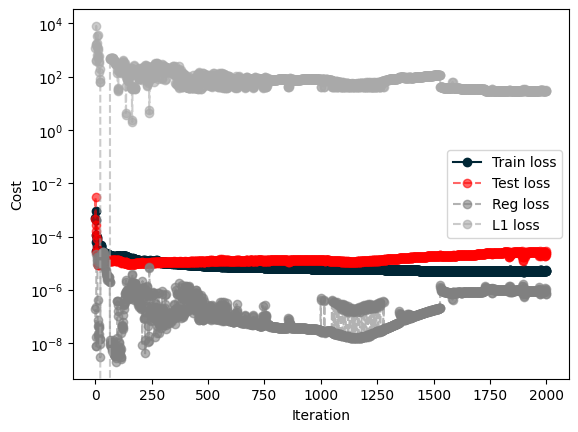

In [26]:
fig, ax = plt.subplots()
ax.plot(train_loss, c='#002635', marker='o', label='Train loss')
ax.plot(test_loss, c='red', marker='o', ls='--', alpha=0.6, label='Test loss')
ax.plot(reg_loss, c='gray', marker='o', ls='--', alpha=0.6, label='Reg loss')
ax.plot(l1_loss, c='darkgray', marker='o', ls='--', alpha=0.6, label='L1 loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.legend()
# plt.xlim([0, 500])

In [27]:
taxon = 1
output = []

for coef in np.arange(n_coefs):
    tmp_file = os.listdir(f"/data/deepymod/ODE_S4/coeffs_output_{taxon}_coeff_{coef}/")[-1]
    file_dir = f"/data/deepymod/ODE_S4/coeffs_output_{taxon}_coeff_{coef}/" + tmp_file

    output_coef = np.array([])
    i = 0
    # os.listdir(file_dir)
    for summary in summary_iterator(file_dir):
        for value in summary.summary.value:
            # Extract relevant information from the event
            coef_val = value.simple_value
            output_coef = np.append(output_coef, coef_val)
            i += 1
    output.append(output_coef)
        

In [28]:
# output

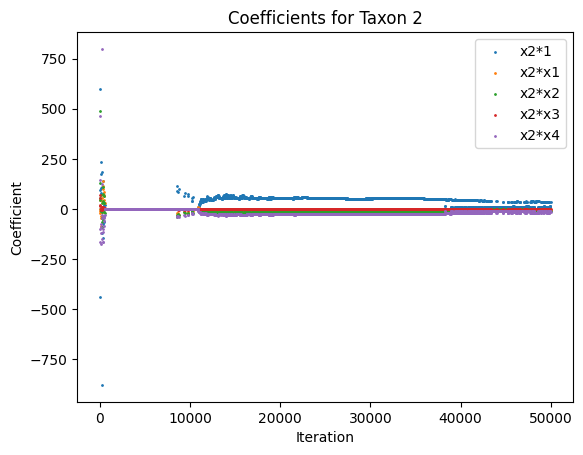

In [29]:
n_iteration = len(output[0])

fig, ax = plt.subplots()
for coef in np.arange(n_coefs):
    # ax.plot(output[coef], marker='o', ls='--', alpha=0.6, label=f'Coef {coef}')
    ax.scatter(np.arange(25*n_iteration, step = 25), output[coef], label = f'{library_values[taxon][coef]}', s=1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Coefficient')
ax.set_title(f'Coefficients for Taxon {taxon+1}')
ax.legend()
# plt.xlim([0, 500])
# plt.ylim([-500, 500])